Data and description - https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data \
This is a dataset from the bank Santander. This is a unique dataset in that the input columns, including the target, are unlabeled/anonymized - i.e. we don't know what each input feature is. \
Our goal is to get the best possible predictive performance for the target variable.

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
import statsmodels.api as sm
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
from skopt.space import Integer
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from tensorflow import keras
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy.special import logit

SEED = 29
MANUAL_RUN = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive'

warnings.simplefilter(action='ignore', category=FutureWarning)

**Unused**

In [ ]:
if MANUAL_RUN:
# TAKEN FROM somang1418'S KERNEL
# https://www.kaggle.com/code/somang1418/tuning-hyperparameters-under-10-minutes-lgbm/notebook
        
    def reduce_mem(df, verbose=True):
        numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2
        i = 0 
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                i += 1
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':                    
                    if c_max<=255:
                        df[col] = df[col].astype('uint8')
                    else:
                        df[col] = df[col].astype('uint16')  
        end_mem = df.memory_usage().sum() / 1024**2
        if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        print('Total colunms changed: ', i)
        return df

**Importing the data**

In [ ]:
# train_df = reduce_mem(pd.read_csv('../input/santander-customer-transaction-prediction/train.csv'))
# test_df = reduce_mem(pd.read_csv('../input/santander-customer-transaction-prediction/test.csv'))

train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

Checking the distribution of target variable

In [ ]:
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

There seems to be imbalance in training data. So using classweights as a parameter might give better results in the model. And also improve recall for test cases.

Checking for null values in the dataset

In [ ]:
train_df.isnull().sum().sum() + test_df.isnull().sum().sum()

0

No null values in the data

In [ ]:
# Outlier Analysis
for feature in features:
    z = np.abs(stats.zscore(df_all[feature]))
    print(feature)
    print(len(np.where(z > 3)[0]))

var_0
54
var_1
14
var_2
20
var_3
40
var_4
116
var_5
6
var_6
87
var_7
36
var_8
14
var_9
0
var_10
126
var_11
227
var_12
25
var_13
1
var_14
12
var_15
46
var_16
50
var_17
248
var_18
20
var_19
5
var_20
5
var_21
250
var_22
278
var_23
137
var_24
17
var_25
113
var_26
64
var_27
8
var_28
171
var_29
69
var_30
26
var_31
510
var_32
3
var_33
20
var_34
22
var_35
214
var_36
182
var_37
1
var_38
495
var_39
151
var_40
36
var_41
2
var_42
60
var_43
24
var_44
92
var_45
66
var_46
181
var_47
17
var_48
113
var_49
18
var_50
176
var_51
69
var_52
286
var_53
33
var_54
66
var_55
0
var_56
376
var_57
183
var_58
359
var_59
80
var_60
9
var_61
140
var_62
155
var_63
288
var_64
33
var_65
260
var_66
144
var_67
366
var_68
69
var_69
17
var_70
20
var_71
55
var_72
140
var_73
54
var_74
287
var_75
18
var_76
117
var_77
22
var_78
18
var_79
3
var_80
16
var_81
87
var_82
12
var_83
11
var_84
84
var_85
14
var_86
74
var_87
157
var_88
36
var_89
72
var_90
15
var_91
57
var_92
62
var_93
514
var_94
0
var_95
90
var_96
16
var_97
23
var_98
132


In [ ]:
df_all = pd.concat([train_df, test_df])
df_all.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,0.100490,10.669326,-1.625933,10.711322,6.792372,11.077366,-5.057938,5.412056,16.537496,0.280648,...,3.212103,7.448339,1.926891,3.326895,17.995376,-0.137873,2.297117,8.910293,15.869952,-3.286439
std,0.300653,3.038398,4.045275,2.637393,2.048028,1.619805,7.866274,0.865652,3.421286,3.333002,...,4.555632,3.024243,1.479193,3.993813,3.137905,1.429530,5.450356,0.921266,3.009828,10.418385
min,0.000000,0.188700,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.216400,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-39.457800
25%,0.000000,8.448900,-4.720800,8.729700,5.242175,9.886975,-11.200825,4.770200,13.938200,-2.310825,...,-0.077200,5.161900,0.886700,0.586075,15.632400,-1.165900,-1.947800,8.255800,13.838500,-11.171300
50%,0.000000,10.518950,-1.599400,10.570000,6.823700,11.104500,-4.833700,5.388500,16.439800,0.383100,...,3.181700,7.363700,1.897000,3.410900,17.967100,-0.167600,2.406800,8.890600,15.939200,-2.769700
75%,0.000000,12.748225,1.350025,12.505300,8.326000,12.256800,0.934700,6.004300,19.099000,2.934025,...,6.373200,9.521700,2.952800,6.191400,20.393800,0.834000,6.539300,9.594900,18.055325,4.889400
max,1.000000,22.323400,10.376800,19.353000,13.188300,16.671400,17.253700,8.447700,28.292800,10.151300,...,20.359000,16.716500,8.402400,18.281800,27.947800,4.545400,18.321500,12.275800,26.538400,28.500700


In [ ]:
## Correlation between columns
corr_data = df_all.drop(['target'], 1).corr()
corr_data.replace(1, 0).max().max()

0.007408270914462057

Maximum correlation is less than 0.0075. Hence the features are almost completely un-correlated.

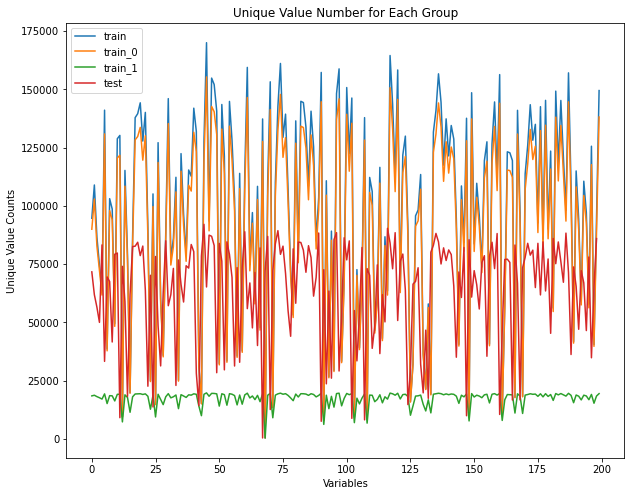

In [ ]:
train_X = train_df[feature]
test_X = test_df[feature]
y = train_df['target']

train_unique = train_X.nunique()
test_unique = test_X.nunique()
train_unique_0 = train_X[train_df['target']==0].nunique()
train_unique_1 = train_X[train_df['target']==1].nunique()


plt.figure(figsize=(10,8))
plt.title("Unique Value Number for Each Group")
plt.xlabel("Variables")
plt.ylabel("Unique Value Counts")
plt.plot(train_unique.values, label = 'train')
plt.plot(train_unique_0.values, label = 'train_0')
plt.plot(train_unique_1.values, label = 'train_1')
plt.plot(test_unique.values[1:],label = 'test')
plt.legend()

It seems like each of the features have lots of repeated values. These noise features can be used to generate additional features.

Y = 0 and Y = 1 have different distributions. Thus it could add to the predictive power of our predictive model.

Getting the indexes of the real and synthetic data in the test dataset. It was important to use this to improve the final score. Taking all test data instead of only the real ones would give inaccurate value counts, thereby decreasing the model performance.

In [ ]:
# REFERENCE FROM YAG320'S KERNEL
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

df_test = test_df.copy()
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in tqdm(range(df_test.shape[1])):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

del df_test, count_, index_, unique_count

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

**Feature Engineering**

Multiple combinations of feature engineering were tried. However, the best one was adding 200 new features representing the value counts for each of the original 200 features.

In [ ]:
if MANUAL_RUN:     
    orig_features = [col for col in train_df.columns if col.startswith('var')]
    df_all = pd.concat([train_df, test_df.iloc[real_samples_indexes]])

    for i, feature in tqdm(enumerate(orig_features)):
            
        temp = df_all[feature].value_counts()
        
        new_feat = feature + 'new'
        
        train_df[new_feat] = train_df[feature].map(temp)
        test_df[new_feat] = test_df[feature].map(temp)
        
        if temp.max()<=255:
            train_df[new_feat] = train_df[new_feat].astype('uint8')
            test_df[new_feat] = test_df[new_feat].astype('uint8')
        else:
            train_df[new_feat] = train_df[new_feat].astype('uint16')
            test_df[new_feat] = test_df[new_feat].astype('uint16')    
            
        new_feat = feature + 'cat_count'

        train_df[new_feat] = train_df[feature].map(temp).map(lambda x: min(50, x)).astype(np.uint8)
        test_df[new_feat] = test_df[feature].map(temp).map(lambda x: min(50, x)).astype(np.uint8)
        
    #     pick min(10,x) where x is the value count - output [1,10]
        train_df[new_feat] = train_df[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)
        test_df[new_feat] = test_df[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)

    #     0 if unique, x-mean if non-unique      ((x - mean)*(0 if unique, 1 if not-unique))
        train_df[feature + 'sum'] = ((train_df[feature] - df_all[feature].mean()) * train_df[feature + 'vc'].map(lambda x: int(x > 1))).astype(np.float32)
        test_df[feature + 'sum'] = ((test_df[feature] - df_all[feature].mean()) * test_df[feature + 'vc'].map(lambda x: int(x > 1))).astype(np.float32) 
        
    #     0 if value_count < 3, otherwise x
        train_df[feature + 'sum2'] = ((train_df[feature]) * train_df[feature + 'vc'].map(lambda x: int(x > 2))).astype(np.float32)
        test_df[feature + 'sum2'] = ((test_df[feature]) * test_df[feature + 'vc'].map(lambda x: int(x > 2))).astype(np.float32)

    #     0 if value_count < 5, otherwise x
        train_df[feature + 'sum3'] = ((train_df[feature]) * train_df[feature + 'vc'].map(lambda x: int(x > 4))).astype(np.float32) 
        test_df[feature + 'sum3'] = ((test_df[feature]) * test_df[feature + 'vc'].map(lambda x: int(x > 4))).astype(np.float32)
        
    del df_all, temp
    print('done')

In [ ]:
orig_features = [col for col in train_df.columns if col.startswith('var')]
df_all = pd.concat([train_df, test_df.iloc[real_samples_indexes]])

for i, feature in tqdm(enumerate(orig_features)):
        
    temp = df_all[feature].value_counts()
    
    new_feat = feature + 'new'
    
    train_df[new_feat] = train_df[feature].map(temp)
    test_df[new_feat] = test_df[feature].map(temp)
    
del df_all, temp
print('done')

**Hyperparameter Tuning**

For custom tuning skopt package was used. Since the tuning time was large, the hyperparameter space was manually split into multiple iterations - with each iteration searching a narrower space than before.

In [ ]:
num_vars = len(orig_features)
n_splits = 4
space  = [Categorical([0.1, 0.25, 0.5], name='learning_rate'),
          Categorical([1.9, 2.0, 2.1, 2.2], name='reg_alpha'),
          Categorical([0, 0.1, 0.2, 0.3], name='reg_lambda'),
          Integer(3, 8, name='num_leaves')]
    
@use_named_args(space)
def evaluate_model(**param):
    
    param['objective'] = 'binary'
    param['feature_fraction'] = 1.0
    param['metric'] = 'auc'
    param['boost_from_average'] = False
    param['boosting_type'] = 'gbdt'
    param['max_depth'] = -1
    param['early_stopping_round'] = 50
    param['seed'] = SEED
    param['is_unbalance'] = True
    param['num_threads'] = 8
    param['verbosity'] = -1 

    oof = pd.DataFrame(np.zeros((test_df.shape[0], len(orig_features))), columns = orig_features)
    
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=SEED)

    for fold, (train_ind, val_ind) in enumerate(skf.split(train_df, train_df.target.values)):

        train = train_df.iloc[train_ind]
        valid = train_df.iloc[val_ind]

        for i in range(num_vars):
            feature = 'var_' + str(i)
            feat_choices = [feature, feature + 'new']

            train_data  = lgb.Dataset(train[feat_choices], label=train['target'])
            val_data = lgb.Dataset(valid[feat_choices], label=valid['target'])     

            model = lgb.train(param, train_data, valid_sets = [train_data, val_data], 
                    verbose_eval=False)

            best_iter = model.best_iteration

            oof[feature].iloc[val_ind] = model.predict(valid[feat_choices], num_iteration=best_iter)

    preds = logit(oof)
    preds = np.sum(oof[[col for col in oof.columns if col.startswith('var')]].values, axis=1)
    
    return -roc_auc_score(train_df[['target']],preds)

In [ ]:
if MANUAL_RUN:
    result = gp_minimize(evaluate_model, space, random_state = SEED, verbose = True)

In [ ]:
if MANUAL_RUN:
    print(result.x)
    print('min auc: ', result.fun)

Using the tuned hyperparamters to train the 200 lgb models

In [ ]:
param = {
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.1,
    'max_depth': -1,
    'metric': 'auc',
    'num_leaves': 3,
    'num_threads': 8,
    'objective': 'binary',
    'reg_alpha': 2,
    'reg_lambda': 0.1,
    'verbosity': -1,
    'is_unbalance' : True,
    'seed': SEED,
    'early_stopping_round': 50
}
    

Running k-fold cross-validation for training 200 models for the 200 original features

In [ ]:
oof = pd.DataFrame(np.zeros((test_df.shape[0], len(orig_features))), columns = orig_features)
# oof['var_ones'] = 1
oof['ID_code'] = train_df[['ID_code']]
oof['target'] = train_df[['target']]

predictions = pd.DataFrame(np.zeros((test_df.shape[0], len(orig_features))), columns = orig_features)
predictions['ID_code'] = test_df[['ID_code']]
# predictions['var_ones'] = 1

In [ ]:
num_vars = len(orig_features)
num_iter = 2000

n_splits = 5
skf = StratifiedKFold(n_splits, shuffle=True, random_state=SEED)

for fold, (train_ind, val_ind) in enumerate(skf.split(train_df, train_df.target.values)):
    
    train = train_df.iloc[train_ind]
    valid = train_df.iloc[val_ind]
    
    for i in range(num_vars):
        feature = 'var_' + str(i)
#         feat_choices = [feature,  feature + 'new',  feature + 'vc', feature + 'sum', feature + 'sum2', feature + 'sum3']
        feat_choices = [feature, feature + 'new']
        
        train_data  = lgb.Dataset(train[feat_choices], label=train['target'])
        val_data = lgb.Dataset(valid[feat_choices], label=valid['target'])     

        model = lgb.train(param, train_data, num_iter, valid_sets = [train_data, val_data], verbose_eval=False)
        
        best_iter = model.best_iteration
        
#         oof.iloc[val_ind][feature] assignment does not work  
        oof[feature].iloc[val_ind] = model.predict(valid[feat_choices], num_iteration=best_iter)
        predictions[feature] += model.predict(test_df[feat_choices], num_iteration=best_iter)/float(n_splits)


del train_data, train, valid, val_data


In [ ]:
if MANUAL_RUN: 
    oof.to_csv('oof', index = False)
    predictions.to_csv('predictions', index = False)

In [ ]:
if MANUAL_RUN:
    oof = pd.read_csv('../input/satander-preds/oof')
    predictions = pd.read_csv('../input/satander-preds/predictions')

In [ ]:
# %whos

In [ ]:
gc.collect()
test_preds = np.zeros(test_df.shape[0])

**Unused**

The following neural network kept running out of memory and could not be trained

In [ ]:
if MANUAL_RUN:
    epochs = 50
    lr_start = 0.02
    batch_size = 4000

    def get_model():
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(601, input_dim=601, activation='elu'))
        model.add(keras.layers.Dense(50, activation='elu'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(40, activation='elu'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(10, activation='elu'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        return model


    num_vars = len(orig_features)

    n_splits = 5
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=SEED)
    
    nn_feat_df = pd.concat([oof, train_df], axis=1)
    not_feature_cols = [col for col in nn_feat_df.columns if not col.startswith('var')]
    nn_feat_df = nn_feat_df.drop(columns = not_feature_cols)
    
    nn_test_feat = pd.concat([predictions, test_df], axis = 1)
    not_feature_cols = [col for col in nn_test_feat.columns if not col.startswith('var')]
    nn_test_feat = nn_test_feat.drop(columns = not_feature_cols)

    
    for fold, (train_ind, val_ind) in tqdm(enumerate(skf.split(oof, oof.target.values))):

        x_train = nn_feat_df.iloc[train_ind]
        x_valid = nn_feat_df.iloc[val_ind]
        y_train = oof.iloc[train_ind]['target']
        y_valid = oof.iloc[val_ind]['target']
        
        optimizer = keras.optimizers.Adam(lr = 0.01, decay = 0.00001)
        model = get_model()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
        model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, verbose=2, batch_size=batch_size)

        test_preds += model.predict(nn_test_feat, batch_size=batch_size)[:,0]/float(n_splits)   

In order to minimize overfitting and utilize the similarity of patterns across different original features, convolutional layers were used. Various different CNN structures along with hyperparameter values were tried.   

In [ ]:
epochs = 100
lr_start = 0.02
batch_size = 4000
num_preds = 3
orig_feat_len = len(orig_features)

# reorder the features to have a variable, its value count and its prediction from lgb next to each other 
def make_nn_feats(predictions, df):
    feat_cols = [col for col in df.columns if col.startswith('var')]
    all_feats = [predictions[orig_features].values, df[feat_cols].values]
    ind_list = []
    for i in range(orig_feat_len):
        ind = np.arange(num_preds)*orig_feat_len + i
        ind_list.append(ind)
    ordered_ind = np.concatenate(ind_list)
    return np.concatenate(all_feats, axis = 1)[:, ordered_ind]

# The architecture is chosen to ensure feature independence until the last dense layer.  
# Batch normalization layers regularize the model well and improve the final score. 
# The model has a total of 2733 trainable parameters which is sufficiently low to not run out of memory and train fast.
# Having low number of trainable parameters also prevents overfitting. 

def get_model():
    inputs = keras.layers.Input((orig_feat_len*num_preds,))
    x = keras.layers.Reshape((orig_feat_len*num_preds,1))(inputs)
    x = keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(24,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(4,1, activation='elu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Reshape((orig_feat_len*4,1))(x)
    x = keras.layers.AveragePooling1D(2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

get_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           128       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 16)           528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            136   

2022-04-21 23:35:21.371457: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
if not MANUAL_RUN:
    num_vars = len(orig_features)

    n_splits = 5
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=SEED)
    
    nn_train = make_nn_feats(oof, train_df)
    nn_test = make_nn_feats(predictions, test_df)

    del train_df, test_df
    
#     without learning rate scheduler, the score was about 0.01 lower
    def get_lr(epoch):
        if epoch <= epochs*0.8:
            return lr_start
        else:
            return lr_start * 0.1


    for fold, (train_ind, val_ind) in tqdm(enumerate(skf.split(oof, oof.target.values))):
        x_train = nn_train[train_ind, :]
        x_valid = nn_train[val_ind, :]
        y_train = oof.iloc[train_ind]['target']
        y_valid = oof.iloc[val_ind]['target']
        
        optimizer = keras.optimizers.Adam(learning_rate = lr_start, decay = 0.00001)
        model = get_model()
        callbacks = [keras.callbacks.LearningRateScheduler(get_lr)]
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
        model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, callbacks=callbacks)
        test_preds += model.predict(nn_test, batch_size=2000)[:,0]/float(n_splits)
        gc.collect()

    del nn_train, nn_test, x_train, x_valid

Combining the predictions using logistic regression

In [ ]:
if MANUAL_RUN:
    lg_feats = orig_features + ['var_ones']

    lr = sm.Logit(oof['target'], oof[lg_feats])
    lr = lr.fit()

    if MANUAL_RUN:
        ensemble_preds = lr.predict(oof[lg_feats])
        roc_auc_score(oof['target'],ensemble_preds)
    
    test_preds = lr.predict(predictions[lg_feats])

Combining the predictions using sum of logit of the individual predictions. This was the best way to combine the results without the CNN

In [ ]:
if MANUAL_RUN:
    predictions_new = predictions.copy()
    predictions_new = logit(predictions_new.drop(columns=['ID_code', 'var_ones']))
    test_preds = np.sum(predictions_new[[col for col in predictions_new.columns if col.startswith('var')]].values, axis=1)

Combing the results as a sum/mean of individual predictions

In [ ]:
if MANUAL_RUN:
    test_preds = np.sum(predictions[[col for col in predictions.columns if col.startswith('var')]].values, axis=1)

Generating the submission file

In [ ]:
submission = pd.DataFrame({'ID_code':pd.Series(predictions['ID_code']),'target':pd.Series(test_preds)})
submission.to_csv('submission.csv',index=False)